# Report - Relationship between the Number of Charging Points and Electromobility in Germany
Niklas Markert <br>
26th June 2023

## Preparation

### Install Dependencies

In [46]:
%pip install numpy
%pip install pandas
%pip install 'SQLAlchemy==1.4.46'
%pip install matplotlib
%pip install geopandas
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Modules

In [47]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import subprocess
from sqlalchemy import create_engine
import urllib.request
import zipfile
from scipy.stats import pearsonr

### Load Data

In [4]:
if not os.path.exists("../data/data.sqlite"):
    subprocess.run(["python", "../data/datapipeline.py"])

con = create_engine('sqlite:///../data/data.sqlite')
df1 = pd.read_sql_table('over_time', con, index_col='Year')
df2 = pd.read_sql_table('by_states', con, index_col='State')

## Introduction

TODO: Maybe some general introduciton: "Electromobility is growing, blablabla"

### Goal
The goal of this project is to analyze the relationship between the number of electric charging stations and electromobility in Germany. <br>
For this we take a look at the amount of charging points overall, combining standard charging points (SCP) and fast charging points (FCP). 
For the effect on electromobility, we will inspect the new registrations of fully electric cars and plug-in-hybrids, because they are the ones depending on charging stations.
<br><br>
In the end, this analysis could help deciding if building more charging stations would lead to a higher rate of electric powered cars.

### Datasources
Here a short listing of the used datasources. For a more detailed description you can check out the [datasources.ipynb](https://github.com/nmarkert/amse/blob/main/project/datasources.ipynb) notebook.

* **Datasource1:** Charging Infrastructure in Germany
    * Link: https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/E-Mobilitaet/Ladesaeulenkarte/start.html
    * Sheet: "4.1 Ladepunkte je BL"
    * Provides the number of charging points for every german state at different points in time from 01.01.2017 until now
<br><br>
* **Datasource2:** New Registrations of Motor Vehicles with Alternative Drive Systems
    * Link: https://mobilithek.info/offers/573357313572614144 _(for 2023)_
    * Sheet: "FZ 28.2" (2.1) + "FZ 28.9" (2.2)
    * Provides the new registrations of motor vehicles with alternative drive systems for each month since January 2016 _(2.1)_ and the new registrations of motor vehicles with alternative drive systems for each german state summed up over the course of a year _(2.2)_
<br> <br>
* **Datasource 3:** German States with Capitals by Area, Population and Population Density
    * Link: https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/02-bundeslaender.html
    * Sheet: "Bundesländer_mit_Hauptstädten"
    * Provides the area and population for each german state and their capital city

### Data transformation
How we transformed and used the data ....

## Analysis

### Development over the years

First let's have a look at the development over the time.

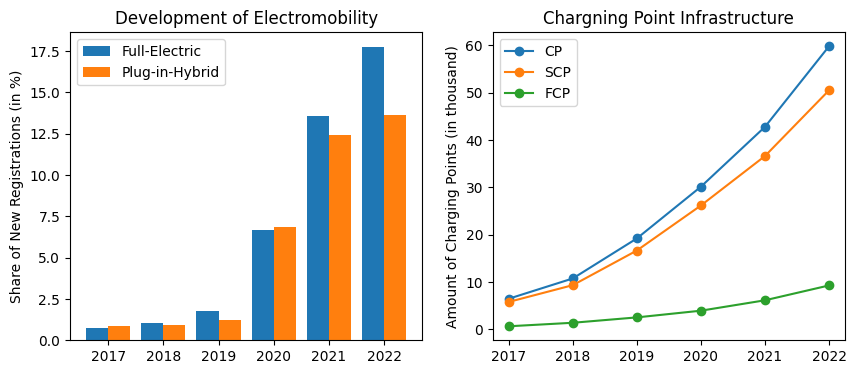

In [5]:
df1.sort_index(ascending=True, inplace=True)
X = df1.index
X_axis = np.arange(len(X))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(X_axis-0.2, (df1['NR Electric']/df1['NR Overall'])*100, 0.4)
plt.bar(X_axis+0.2, (df1['NR Plug-in-Hybrid']/df1['NR Overall'])*100, 0.4)
plt.legend(['Full-Electric', 'Plug-in-Hybrid'])
plt.title('Development of Electromobility')
plt.ylabel('Share of New Registrations (in %)')
plt.xticks(X_axis, X)

plt.subplot(1, 2, 2)
plt.plot(X_axis, df1['Amount CP']/1000, 'o-')
plt.plot(X_axis, df1['Amount SCP']/1000, 'o-')
plt.plot(X_axis, df1['Amount FCP']/1000, 'o-')
plt.legend(['CP', 'SCP', 'FCP'])
plt.title('Chargning Point Infrastructure')
plt.xticks(X_axis, X)
plt.ylabel('Amount of Charging Points (in thousand)')

plt.show()

As you can see in the first graphic the percentage share of new regestrations for both full-electric cars and plug-in-hybrids are increasing, especially in recent years. <br>
The same applies for the amount of charging points in germany. They are steadily increasing and especially in recent years with a much higher slope than in the early years. <br>
<br>
However, to assume a dependency here would be too vague. There are a lot of factors which also effect these increases, especially the change in society and the car industry over the time.
In society, saving the environment, e.g. by using sustainable energy, is a big topic and also is increasing over the years. 
This topic goes hand in hand with the state of the car industry. Also the amount of available electric cars is steadily increasing, because more and more car manifacturer offer a wider cars with alternative drive systems.
<br><br>
So its hard to argue that the amount of charging points influence the electromobility in germany, just because both values are rapidly increasing over time. <br>
For this reason, we now will take a look at a specific point in time and have a look at the charging infrastructure and electromobility at the different states of Germany.

### Comparison between the different German States

In this chapter, we will use abbrevations for the different german states in the plots.
So if you are unclear which state a specific abbrevations refers to, you can have a look here.

In [6]:
df2['Abbreviation']

State
Baden-Württemberg         BW
Bayern                    BY
Berlin                    BE
Brandenburg               BB
Bremen                    HB
Hamburg                   HH
Hessen                    HE
Mecklenburg-Vorpommern    MV
Niedersachsen             NI
Nordrhein-Westfalen       NW
Rheinland-Pfalz           RP
Saarland                  SL
Sachsen                   SN
Sachsen-Anhalt            ST
Schleswig-Holstein        SH
Thüringen                 TH
Germany                   DE
Name: Abbreviation, dtype: object

In [7]:
# TODO Outfactor this to preperation -> prepare data
df2['CP per km^2'] = df2['Amount CP'] / df2['Area (km^2)']
df2['SCP per km^2'] = df2['Amount SCP'] / df2['Area (km^2)']
df2['FCP per km^2'] = df2['Amount FCP'] / df2['Area (km^2)']
df2['Percentage Electric'] = (df2['NR Plug-in-Hybrid'] + df2['NR Electric']) / df2['NR Overall']
df2['Percentage Full-Electric'] = df2['NR Electric'] / df2['NR Overall']
df2['Percentage Plug-in-Hybrid'] = df2['NR Plug-in-Hybrid'] / df2['NR Overall']

In [8]:
ger = df2.loc['Germany']
df2.drop(index='Germany', inplace=True)

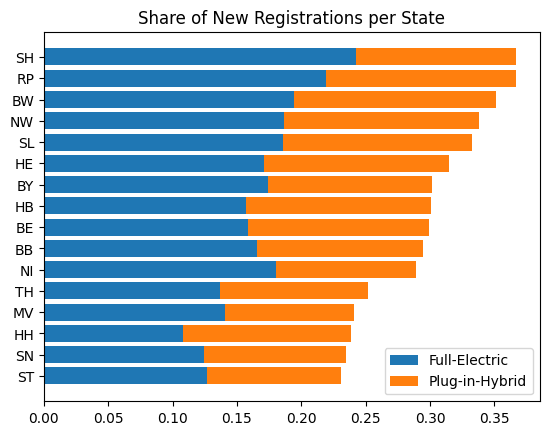

In [9]:
df2.sort_values('Percentage Electric', inplace=True)
plt.barh(df2['Abbreviation'], df2['Percentage Full-Electric'], label='Full-Electric')
plt.barh(df2['Abbreviation'], df2['Percentage Plug-in-Hybrid'], left=df2['Percentage Full-Electric'], label='Plug-in-Hybrid')
plt.legend()
plt.title('Share of New Registrations per State')
plt.show()

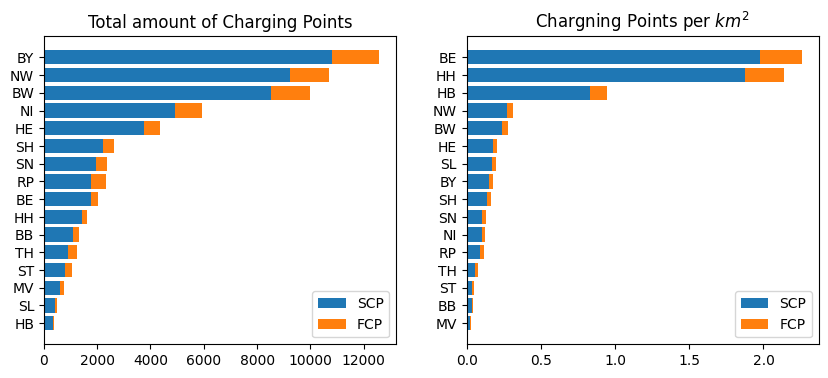

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df2.sort_values('Amount CP', inplace=True)
plt.barh(df2['Abbreviation'], df2['Amount SCP'], label='SCP')
plt.barh(df2['Abbreviation'], df2['Amount FCP'], left=df2['Amount SCP'], label='FCP')
plt.title('Total amount of Charging Points')
plt.legend()

plt.subplot(1, 2, 2)
df2.sort_values('CP per km^2', inplace=True)
plt.barh(df2['Abbreviation'], df2['SCP per km^2'], label='SCP')
plt.barh(df2['Abbreviation'], df2['FCP per km^2'], left=df2['SCP per km^2'], label='FCP')
plt.title('Chargning Points per $km^2$')
plt.legend()

plt.show()

Left: Total amount of charging points -> bit states have higher amount of charging points
-> Set amount of charging points in relation to the area
Right: Charging points per square-kilometer -> "Stadtstaaten" (Berlin, Bremen, Hamburg) stands out because of the small area
-> We will remove them from analysis

In [11]:
df2.drop(index=['Berlin', 'Hamburg', 'Bremen'], inplace=True)

In [12]:
# TODO Maybe also factor out to preparation

# Download the needed file if not already existing
if not os.path.exists('./DEU_adm/'):
    urllib.request.urlretrieve('https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip', 'DEU_adm.zip')
    with zipfile.ZipFile('DEU_adm.zip', 'r') as zip_ref:
        zip_ref.extractall('DEU_adm')
    os.remove('DEU_adm.zip')
    
# Create the dataframe and add the columns to investigate
df_ger = gpd.read_file('./DEU_adm/DEU_adm1.shp') 
df_ger = df_ger.set_index('NAME_1')
df_ger['Percentage Electric'] = df2['Percentage Electric']
df_ger['CP per km^2']  = df2['CP per km^2'] 

Lets see the values on the map .....

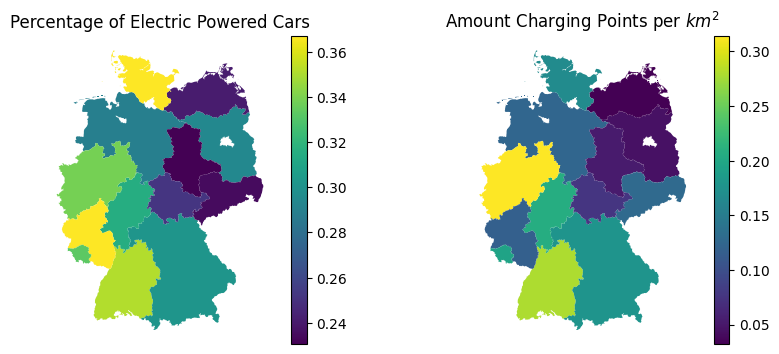

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

df_ger.plot(column='Percentage Electric', kind='geo', legend=True, ax=ax1)
ax1.axis('off')
ax1.set_title('Percentage of Electric Powered Cars')

df_ger.plot(column='CP per km^2', kind='geo', legend=True, ax=ax2)
ax2.axis('off')
ax2.set_title('Amount Charging Points per $km^2$')

plt.show()

Calculate the Correlation of Different Variables .....

In [68]:
cols1 = ['Percentage Electric', 'Percentage Full-Electric', 'Percentage Plug-in-Hybrid']
cols2 = ['CP per km^2', 'SCP per km^2', 'FCP per km^2']

correlations = []
for c1 in cols1:
    for c2 in cols2:
        corr, pvalue = pearsonr(df2[c1], df2[c2])
        correlations.append({
            'x': c1,
            'y': c2,
            'Correlation Coefficient': corr,
            'p-Value': pvalue
        })

df_corr = pd.DataFrame(correlations, columns=correlations[0].keys())
df_corr.set_index(['x', 'y'], inplace=True)
df_corr.sort_values('Correlation Coefficient', ascending=False)

Correlation Coefficient   p-Value
x                         y                                              
Percentage Plug-in-Hybrid FCP per km^2                 0.784702  0.001489
                          CP per km^2                  0.779542  0.001678
                          SCP per km^2                 0.771761  0.001998
Percentage Electric       FCP per km^2                 0.689617  0.009106
                          CP per km^2                  0.653076  0.015511
                          SCP per km^2                 0.642030  0.017988
Percentage Full-Electric  FCP per km^2                 0.535684  0.059188
                          CP per km^2                  0.487002  0.091441
                          SCP per km^2                 0.475752  0.100329

## Conclusion
TODO:
* What do we conclude from our findings
* What effects does that have
* ...